In [1]:
# baixei o grafico da noticia em 2015-03-15 às 01:02:03
#!wget http://s2.glbimg.com/dSOq2KmDstd2L_434azcbAHSPjc=/s.glbimg.com/jo/g1/f/original/2015/03/14/reservatorios1403.jpg

Acho que esse gráfico do G1 tá errado

G1 São Paulo
##Nível de água do Cantareira vai a 14,5%; todos reservatórios sobem
[link da notícia](http://g1.globo.com/sao-paulo/noticia/2015/03/cantareira-vai-145-todos-reservatorios-sobem.html)

<!---![g1](reservatorios1403.jpg)-->

In [2]:
from IPython.display import display, Image

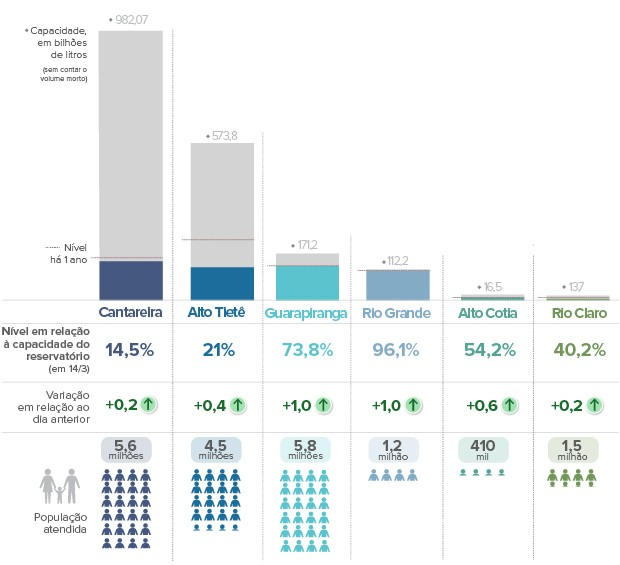

In [3]:
## eis a imagem da notícia
infograficoG1 = Image('reservatorios1403.jpg')
display(infograficoG1)

A sabesp disponibiliza dados para consulta [neste endereço](http://www2.sabesp.com.br/mananciais/DivulgacaoSiteSabesp.aspx), mas não faço idéia de como pegar os dados com o python... 

ainda bem que uma boa alma já fez uma api que dá conta do serviço!

In [4]:
import urllib.request
req = urllib.request.urlopen("https://sabesp-api.herokuapp.com/").read().decode()

In [5]:
import json
data = json.loads(req)

In [6]:
import datetime as dt
print('dados disponibilizados pela sabesb hoje, %s \n-----' % dt.date.today())
for x in data:
    print (x['name'])
    for i in range(len(x['data'])):
        item = x['data'][i]
        print ('item %d) %35s   =   %s' % (i, item['key'], item['value']))
        
    #print ( [item['value'] for item in x['data'] ])
    print('-----')

dados disponibilizados pela sabesb hoje, 2015-03-15 
-----
Cantareira
item 0)                   volume armazenado   =   14,6 %
item 1)                 pluviometria do dia   =   0,3 mm
item 2)       pluviometria acumulada no mês   =   138,9 mm
item 3)              média histórica do mês   =   178,0 mm
-----
Alto Tietê
item 0)                   volume armazenado   =   21,5 %
item 1)                 pluviometria do dia   =   1,8 mm
item 2)       pluviometria acumulada no mês   =   130,7 mm
item 3)              média histórica do mês   =   172,4 mm
-----
Guarapiranga
item 0)                   volume armazenado   =   74,7 %
item 1)                 pluviometria do dia   =   6,0 mm
item 2)       pluviometria acumulada no mês   =   132,6 mm
item 3)              média histórica do mês   =   153,2 mm
-----
Alto Cotia
item 0)                   volume armazenado   =   54,7 %
item 1)                 pluviometria do dia   =   6,0 mm
item 2)       pluviometria acumulada no mês   =   85,2 mm
item 3)  

In [7]:
## com isso posso usar list comprehension para pegar os dados que me interessam
[ (x['name'], x['data'][0]['value']) for x in data ] 

[('Cantareira', '14,6 %'),
 ('Alto Tietê', '21,5 %'),
 ('Guarapiranga', '74,7 %'),
 ('Alto Cotia', '54,7 %'),
 ('Rio Grande', '97,8 %'),
 ('Rio Claro', '40,4 %')]

In [8]:
import datetime as dt
# datas usadas no grafico do G1
today = dt.date(2015,3,14)
yr = dt.timedelta(days=365)
last_year = today - yr

today=today.isoformat()
last_year=last_year.isoformat()

In [9]:
def getData(date):
    """recebe um objeto date ou uma string com a data no 
    formato YYYY-MM-DD e retorna uma 'Série' (do pacote pandas)
    com os níveis dos reservatórios da sabesp"""
    
#     def parsePercent(s):
#         """recebe uma string no formato '\d*,\d* %' e retorna o float equivalente"""
#         return float(s.replace(",",".").replace("%",""))
#    da pra fazer com o lambda tbm, huehue
    fixPercent = lambda s: float(s.replace(",",".").replace("%",""))
    
    import datetime
    if type(date) == datetime.date:
        date = date.isoformat()
    
    ## requisição
    import urllib.request
    req = urllib.request.urlopen("https://sabesp-api.herokuapp.com/" + date).read().decode()
    
    ## transforma o json em dicionario
    import json
    data = json.loads(req)
    
    ## serie
    dados = [ fixPercent(x['data'][0]['value']) for x in data ]
    sistemas = [ x['name'] for x in data ]
    
    import pandas as pd
    return pd.Series(dados, index=sistemas, name=date)   

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns ## só pra deixar o matplotlib com o estilo bonitão do seaborn ;)

#pd.options.display.mpl_style = 'default'

In [11]:
df = pd.DataFrame([getData(today), getData(last_year)]) #, index=[today, last_year])

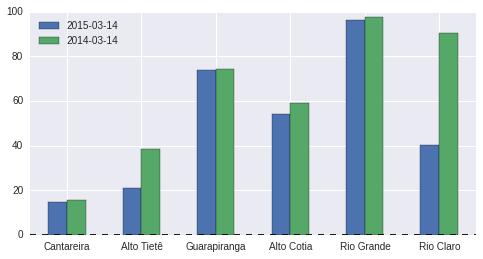

,Cantareira,Alto Tietê,Guarapiranga,Alto Cotia,Rio Grande,Rio Claro
2015-03-14,14.5,21.0,73.8,54.2,96.1,40.2
2014-03-14,15.5,38.5,74.4,59.1,97.6,90.6


In [12]:
df.T.plot(kind='bar', rot=0, figsize=(8,4))
plt.show()

df

OK. Tudo certo. Bate com os gráficos mostrados pelo G1, apenas está sendo mostrado de uma forma diferente. 

Só temos um pequeno problema aí: esses percentuais são em relação à capacidade reservatório na data consultada. Acontece que, pelo menos para o Cantareira e o Alto Tietê, esse volume VARIA (volume morto mandou um oi). 

Vejam:

In [13]:
datas = [last_year,
         '2014-05-15', # pré-volume morto
         '2014-05-16', # estréia da "primeira reserva técnica", a.k.a. volume morto
         '2014-07-12',
         '2014-10-23',
         '2014-10-24', # "segunda reserva técnica" ou "VOLUME MORTO 2: ELECTRIC BOOGALOO"
         '2015-01-01', # feliz ano novo ?
         today]
import numpy as np
df = pd.DataFrame(pd.concat(map(getData, datas), axis=1))

In [14]:
df = df.T

In [15]:
df

,Cantareira,Alto Tietê,Guarapiranga,Alto Cotia,Rio Grande,Rio Claro
2014-03-14,15.5,38.5,74.4,59.1,97.6,90.6
2014-05-15,8.2,33.0,74.4,46.9,93.2,98.6
2014-05-16,26.7,32.8,74.1,46.7,92.8,98.3
2014-07-12,18.5,23.9,69.1,45.6,90.0,92.6
2014-10-23,3.0,8.2,41.9,30.2,71.2,49.7
2014-10-24,13.6,8.0,41.5,30.0,70.9,49.1
2015-01-01,7.2,12.1,40.6,31.4,71.9,32.5
2015-03-14,14.5,21.0,73.8,54.2,96.1,40.2


In [16]:
def plotSideBySide(dfTupl, cm=['Spectral', 'coolwarm']):
    fig, axes = plt.subplots(1,2, figsize=(17,5))

    for i, ax in enumerate(axes):
        dfTupl[i].ix[:].T.plot(
            kind='bar', ax=ax,
            rot=0, colormap=cm[i])

        #itens = dfTupl[i].ix[:,sistemas]

        for j in range(len(dfTupl[i].columns)):
            itens = dfTupl[i].ix[:,j]
            y = 0
            if itens.max() > 0:
                y = itens.max()
            ax.text(j, y +0.5, 
                '$\Delta$\n{:0.1f}%'.format(itens[1] - itens[0]), 
                ha='center', va='bottom', 
                fontsize=14, color='k')

    plt.show()

In [17]:
#%psource plotaReservatecnica

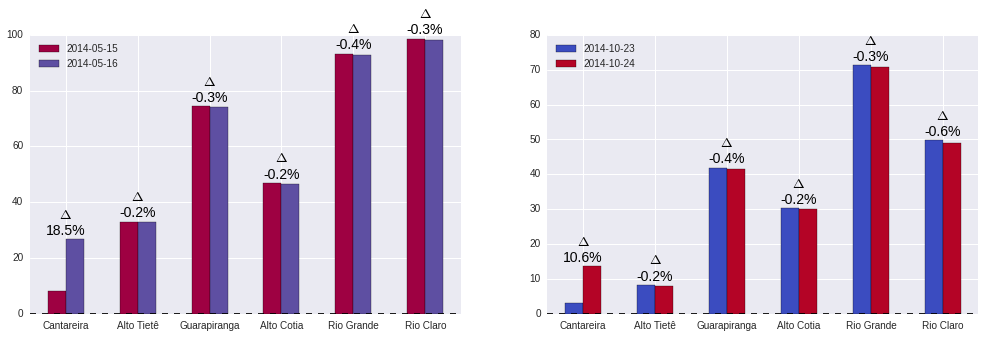

In [18]:
dados = df.ix[['2014-05-15','2014-05-16']], df.ix[['2014-10-23','2014-10-24']]

plotSideBySide(dados)

o cantareira tem capacidade total de quase 1 trilhão de litros, segundo a matéria do G1. 

Então, entre os dias 15 e 16 de março, *POOF*: **180 bilhões** de litros surgiram num passe de mágica!

Depois, em outubro, *POOF*. Surgem mais **100 bilhões**. 


#QUE BRUXARIA É ESSA?!?

O próprio [site](http://www2.sabesp.com.br/mananciais/DivulgacaoSiteSabesp.aspx) da sabesp esclarece:


- A **primeira reserva técnica** entrou em operação em **16/05/2014** e acrescentou mais **182,5 bilhões** de litros ao sistema - 18,5% de acréscimo;

- A **segunda reserva técnica** entrou em operação em **24/10/2014** e acrescentou mais **105,4 bilhões** de litros ao sistema - 10,7% de acréscimo 


Ou seja, o grafico do G1 realmente está errado. Alguém avisa os caras.

In [19]:
def fixCantareira(p, data):
    """corrige o percentual divulgado pela sabesp"""
    
    def str2date(data, format='%Y-%m-%d'):
        """converte uma string contendo uma data e retorna um objeto date"""
        import datetime as dt
        return dt.datetime.strptime(data,format)
        
    vm1day = str2date('16/05/2014', format='%d/%m/%Y')
    vm2day = str2date('24/10/2014', format='%d/%m/%Y')
    
    vm1 = 182.5
    vm2 = 105.4
    
    def percReal(perc,volumeMorto=0):
        a = perc/100
        volMax = 982.07
        volAtual = volMax*a -volumeMorto
        b = 100*volAtual/volMax
        b = np.round(b,1)
        return b
    
    
    if str2date(data) < vm1day:
        print(data, p, end=' ')
        perc = percReal(p)
        print('===>', perc)
        return perc
    
    elif str2date(data) < vm2day:
        print('primeira reserva técnica em uso', data, p, end=' ')
        perc = percReal(p, volumeMorto=vm1)
        print('===>', perc)
        return perc
        
    else:
        print('segunda reserva técnica em uso', data, p, end=' ')
        perc = percReal(p, volumeMorto=vm1+vm2)
        print('===>', perc)
        return perc
        

In [20]:
dFixed = df.copy()

In [21]:
dFixed.Cantareira = ([fixCantareira(p, dia) for p, dia in zip(df.Cantareira, df.index)])

2014-03-14 15.5 ===> 15.5
2014-05-15 8.2 ===> 8.2
primeira reserva técnica em uso 2014-05-16 26.7 ===> 8.1
primeira reserva técnica em uso 2014-07-12 18.5 ===> -0.1
primeira reserva técnica em uso 2014-10-23 3.0 ===> -15.6
segunda reserva técnica em uso 2014-10-24 13.6 ===> -15.7
segunda reserva técnica em uso 2015-01-01 7.2 ===> -22.1
segunda reserva técnica em uso 2015-03-14 14.5 ===> -14.8


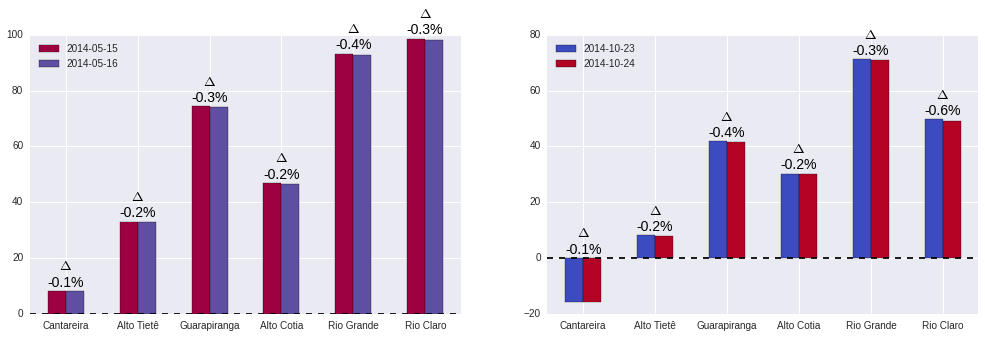

In [22]:
dados = dFixed.ix[['2014-05-15','2014-05-16']], dFixed.ix[['2014-10-23','2014-10-24']]

plotSideBySide(dados)

AAAAAAAAH, AGORA SIM! Corrigido. Agora vamos comparar o grafico com os dados usados pelo G1 e o com dados corrigidos

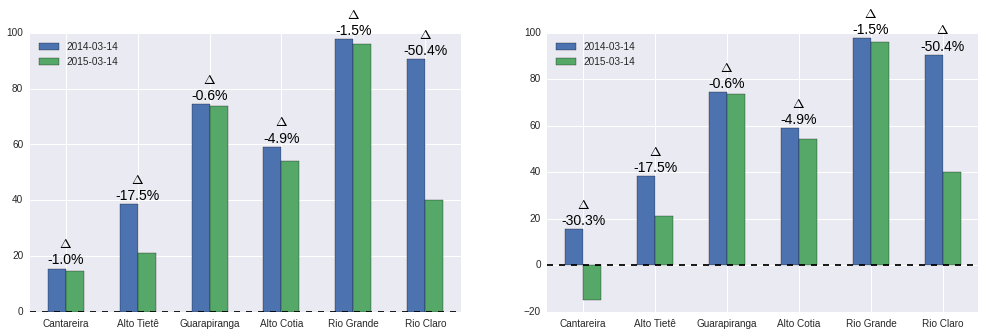

In [23]:
dias = ['2014-03-14','2015-03-14']
dados = df.ix[dias,:], dFixed.ix[dias,:]

plotSideBySide(dados,cm=[None,None])

G1 errou 30%. errou feio, errou rude.

Estamos muito longe do nível do ano passado. E, mesmo que estivessemos com 15% da capacidade do cantareira, ainda seria uma situação crítica.

PS: Ainda faltou corrigir o percentual pro Alto Tietê, que também está usando uma "reserva técnica".

In [24]:
dFixed.ix[dias]

,Cantareira,Alto Tietê,Guarapiranga,Alto Cotia,Rio Grande,Rio Claro
2014-03-14,15.5,38.5,74.4,59.1,97.6,90.6
2015-03-14,-14.8,21.0,73.8,54.2,96.1,40.2
